# Image Object Detection
**This project is about object detection, one of the areas of computer vision that is substantially advanced over the last couple of years.**

## Object Detection Task
The object detection task is based on following two prerequisite stages:
- Image classification: a supervised learning process to train an algorithm to recognize a set of target classes (objects to identify in images) using labeled example photos.
- Image classification with localization: the process of training a supervised algorithm to predict class as well as the bounding box around the object in the image. The term 'localization' refers to identifying the location of the object in the image. 

The object detection task refers to the situation where the model needs to detect multiple objects in the picture and localized them all by defining a bounding box around them. A prime example is an autonomous driving application, which needs to detect not just other cars, but also other pedestrians and motorcycles and even other objects. 

## YOLO algorithm
In recent years, deep learning algorithms are offering cutting-edge improved results for object detection. YOLO algorithm is one of the most popular Convolutional Neural Networks with a single end-to-end model that can perform object detection in real-time. YOLO stands for, You Only Look Once and is an algorithm developed by Joseph Redmon, et al. and first described in the 2015 paper titled “You Only Look Once: Unified, Real-Time Object Detection. The creation of the algorithm stemmed from the idea to place down a grid on the image and apply the image classification and localization algorithm to each of the grids.
Here the YOLOv3, a refined design which uses predefined anchor boxes to improve bounding box, is utilized for object detection in new images. Source code and pre-trained models of YOLOv3 is available in the official DarkNet GitHub repository.


In [1]:
import numpy as np
import pandas as pd
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
from IPython.display import display, HTML

## using YOLO with Keras
There are many third-party implementations designed for using YOLO with Keras. One of the most popular implementations is called “keras-yolo3: Training and Detecting Objects with YOLO3” by Huynh Ngoc Anh or experiencer. Here, some of the functions from a Python file in that repository called “yolo3_one_file_to_detect_them_all.py” will be used to load pre-trained weights and prepare a model and use that model to perform object detection. 


In [2]:
from yolo3_one_file_to_detect_them_all import decode_netout, correct_yolo_boxes, bbox_iou, do_nms, _sigmoid, BoundBox, _interval_overlap, _conv_block, make_yolov3_model, WeightReader

## Create and Save Model
The first step is to download the pre-trained model weights using the DarkNet code base on the MSCOCO dataset and place them into current working directory with the filename “yolov3.weights.” It is a large file and may take a moment to download.





- **YOLOv3 Pre-trained Model Weights can be downloaded at** <a href="https://pjreddie.com/media/files/yolov3.weights" target="_blank">yolov3.weights(237 MB)</a>.

Next, we need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model. The “yolo3_one_file_to_detect_them_all.py” script provides the make_yolov3_model() function to create the model and the helper function _conv_block() to create blocks of layers. We can now define the Keras model for YOLOv3.

Next, we need to load the model weights using the WeightReader class provided in the script. Calling of the load_weights() function of the WeightReader instance results in Keras model to set the weights into the layers.

Now the YOLOv3 model is ready to use. Let's save the model as a Keras compatible .h5 model file for later use.

In [3]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

C:\Users\mhoss\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**The first step is to load the previously saved Keras model. The model expects image inputs to be color images with the square shape of 416×416 pixels.**

In [4]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416

Next, using the load_img() Keras function to load the image and prepare it as suitable input to the model through the following steps:
- target_size argument resizes the image after loading
- img_to_array() function converts the loaded PIL image object into a NumPy array
- rescaling the pixel values from 0-255 to 0-1 32-bit floating point values

The original shape of image will be save becasue:
- we will show the original photo again later 
- bounding boxes of all detected objects will be scaled from the square shape back to the original shape.

**All above features are wrapped in a function called load_image_pixels.**

In [5]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

**Following is a list of strings containing the class labels known to the model in the correct order used during training, specifically those class labels from the MSCOCO dataset.**

In [6]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

The function image_object_detector takes the photo filename, feed the Keras model with target size and scaled pixel data as input and make a prediction (yhat). The output of the model are encoded versions of detected objects, bounding boxes and class labels. 

The “yolo3_one_file_to_detect_them_all.py” script includes a function called decode_netout() that decode bounding boxes and class predictions from output NumPy arrays. Using class_threshold = 0.6, any bounding boxes that don’t confidently describe an object will be ignored. The function returns a list of BoundBox instances that define the corners of each bounding box in the context of the input image shape and class probabilities.

Next, the correct_yolo_boxes() function is used to stretch back the bounding boxes into the shape of the original image, As the original image will be plotted with the detected objects marked by drawing of the bounding boxes.

It is likely that any of detected objects are identified by multiple overlapping bounding boxes. We used non max suppression threshold (NMS_threshold) = 0.5 to filter overlapping bounding boxes that are referring to the same objects. It is implemented by do_nms() function that takes the list of bounding boxes and a threshold parameter. Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. This allows the boxes to remain and be used if they also detect another object type.

The get_boxes() function retrieve just those boxes that strongly predict the presence of an object: that is the corresponding class label for the box is larger than class_threshold confident.

The draw_boxes() function below takes the filename of the original photograph and the lists of bounding boxes, labels and scores, and creates a plot showing all detected objects by drawing the bounding box around each detected object and write a string with the class label and confidence.

In [7]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    plt.figure(figsize = (16,8))
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()
    return

def image_object_detector(photo_filename, print_classes=False, class_threshold = 0.6, NMS_threshold = 0.5):
    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    # make prediction
    yhat = model.predict(image)
    # define the probability threshold for detected objects
    #class_threshold = 0.6
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold,NMS_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, NMS_threshold)
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    if (print_classes):
        # summarize what we found
        results = pd.DataFrame({'Identified Objects':v_labels, 'Probability (%)': v_scores})
        results['Probability (%)']=results['Probability (%)'].apply(lambda x:round(x,2))
        display(HTML(results.to_html()))

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
    return 

,Identified Objects,Probability (%)
0,zebra,99.83
1,zebra,93.61
2,zebra,97.34


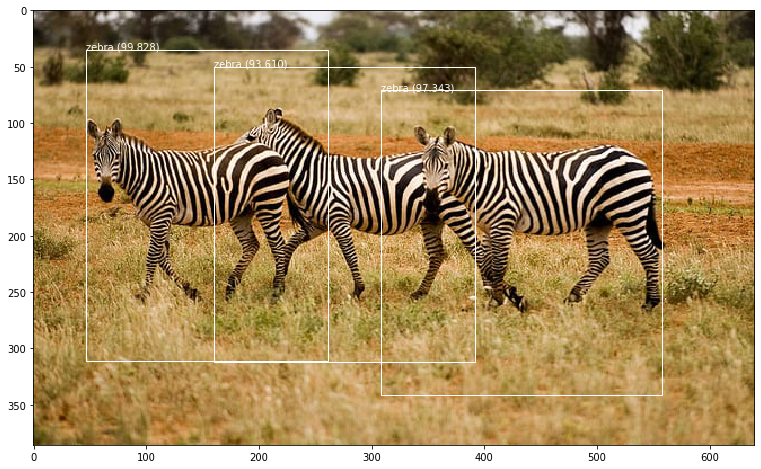

In [11]:
# define our new photo
photo_filename = 'images\zebra.jpg'
image_object_detector(photo_filename, print_classes=True)

,Identified Objects,Probability (%)
0,giraffe,99.87
1,giraffe,98.86


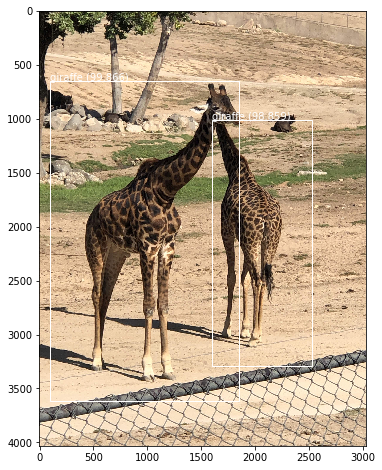

In [12]:
# define our new photo
photo_filename = 'images\giraffe.jpg'
image_object_detector(photo_filename, print_classes=True)

,Identified Objects,Probability (%)
0,person,99.94
1,cell phone,94.83
2,person,63.07
3,giraffe,98.34
4,giraffe,97.27


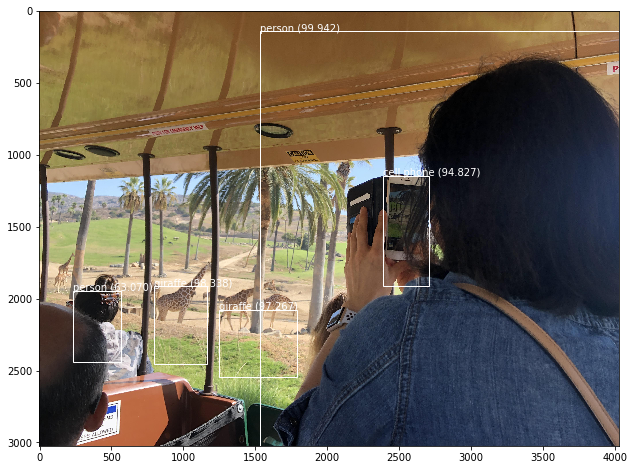

In [14]:
# define our new photo
photo_filename = 'images\Safari.jpg'
image_object_detector(photo_filename, print_classes=True)